In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, embed_size)

    def forward(self, images):
        return self.model(images)

In [2]:
from transformers import DistilBertModel, DistilBertTokenizer

class TextEncoder(nn.Module):
    def __init__(self, embed_size):
        super(TextEncoder, self).__init__()
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.fc = nn.Linear(self.model.config.hidden_size, embed_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state[:, 0, :]
        return self.fc(hidden_states)

In [3]:
import torch.nn.functional as F

def contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    image_embeddings = F.normalize(image_embeddings, dim=-1)
    text_embeddings = F.normalize(text_embeddings, dim=-1)

    logits = torch.matmul(image_embeddings, text_embeddings.T) / temperature

    labels = torch.arange(len(image_embeddings)).to(image_embeddings.device)

    loss_img = F.cross_entropy(logits, labels)
    loss_text = F.cross_entropy(logits.T, labels)

    return (loss_img + loss_text) / 2

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class_descriptions = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def encode_text(class_idx):
    text = f"A photo of a {class_descriptions[class_idx]}"
    encoding = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    return encoding['input_ids'], encoding['attention_mask']

100%|██████████| 170498071/170498071 [00:19<00:00, 8615376.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_encoder = ImageEncoder(embed_size=256).to(device)
text_encoder = TextEncoder(embed_size=256).to(device)

optimizer = torch.optim.Adam(list(image_encoder.parameters()) + list(text_encoder.parameters()), lr=1e-4)

for epoch in range(30):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        image_embeddings = image_encoder(images)

        input_ids, attention_mask = zip(*[encode_text(label.item()) for label in labels])
        input_ids = torch.cat(input_ids).to(device)
        attention_mask = torch.cat(attention_mask).to(device)

        text_embeddings = text_encoder(input_ids=input_ids, attention_mask=attention_mask)

        loss = contrastive_loss(image_embeddings, text_embeddings)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.9MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1, Loss: 1.220200777053833
Epoch 2, Loss: 0.8003277778625488
Epoch 3, Loss: 1.1054383516311646
Epoch 4, Loss: 1.393660068511963
Epoch 5, Loss: 0.9134875535964966
Epoch 6, Loss: 0.9263306856155396
Epoch 7, Loss: 1.1752413511276245
Epoch 8, Loss: 0.8408141136169434
Epoch 9, Loss: 0.7632184624671936
Epoch 10, Loss: 0.7763972282409668
Epoch 11, Loss: 0.6728966236114502
Epoch 12, Loss: 0.891179621219635
Epoch 13, Loss: 0.7859888076782227
Epoch 14, Loss: 0.799429714679718
Epoch 15, Loss: 0.6468230485916138
Epoch 16, Loss: 0.9626656174659729
Epoch 17, Loss: 0.7132567167282104
Epoch 18, Loss: 0.8226668834686279
Epoch 19, Loss: 1.271345853805542
Epoch 20, Loss: 0.6748796701431274
Epoch 21, Loss: 0.7590544819831848
Epoch 22, Loss: 0.7321673035621643
Epoch 23, Loss: 0.6814960241317749
Epoch 24, Loss: 0.8969549536705017
Epoch 25, Loss: 0.7079794406890869
Epoch 26, Loss: 1.162589192390442
Epoch 27, Loss: 0.9928737878799438
Epoch 28, Loss: 0.81575608253479
Epoch 29, Loss: 0.6735138893127441
Ep

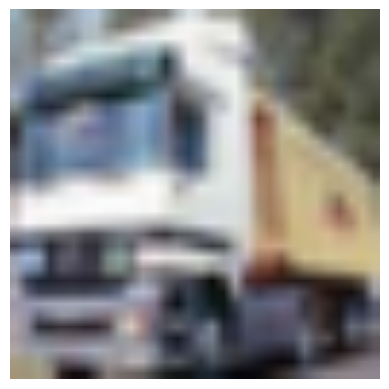

Best match: A photo of a automobile


In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_image(image_tensor):
    unloader = transforms.ToPILImage()
    image = image_tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

def predict(image, text_descriptions):
    show_image(image)

    image = image.unsqueeze(0).cuda()
    image_embedding = image_encoder(image)

    text_embeddings = []
    for description in text_descriptions:
        input_ids, attention_mask = tokenizer(description, return_tensors='pt', padding=True, truncation=True).values()
        input_ids, attention_mask = input_ids.cuda(), attention_mask.cuda()
        text_embeddings.append(text_encoder(input_ids=input_ids, attention_mask=attention_mask))

    text_embeddings = torch.cat(text_embeddings).cuda()

    image_embedding = F.normalize(image_embedding, dim=-1)
    text_embeddings = F.normalize(text_embeddings, dim=-1)
    similarities = torch.matmul(image_embedding, text_embeddings.T).squeeze()

    best_match_idx = similarities.argmax().item()
    return text_descriptions[best_match_idx]

image = train_data[1][0]
descriptions = ["A photo of a airplane", "A photo of a automobile", "A photo of a bird", "A photo of a cat", "A photo of a deer", "A photo of a dog", "A photo of a frog",
                "A photo of a horse", "A photo of a ship", "A photo of a truck"]
best_match = predict(image, descriptions)
print(f"Best match: {best_match}")

# Save and Load Model

In [12]:
torch.save({
    'image_encoder_state_dict': image_encoder.state_dict(),
    'text_encoder_state_dict': text_encoder.state_dict(),
}, 'model.pth')

In [15]:
image_encoder = ImageEncoder(embed_size=256).to(device)
text_encoder = TextEncoder(embed_size=256).to(device)

checkpoint = torch.load('model.pth', weights_only=True)
image_encoder.load_state_dict(checkpoint['image_encoder_state_dict'])
text_encoder.load_state_dict(checkpoint['text_encoder_state_dict'])

image_encoder.eval()
text_encoder.eval()

TextEncoder(
  (model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

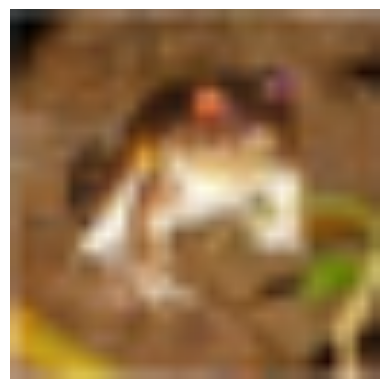

Best match: A photo of a frog


In [16]:
def predict(image, text_descriptions):
    show_image(image)

    image = image.unsqueeze(0).to(device)
    image_embedding = image_encoder(image)

    text_embeddings = []
    for description in text_descriptions:
        input_ids, attention_mask = tokenizer(description, return_tensors='pt', padding=True, truncation=True).values()
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        text_embeddings.append(text_encoder(input_ids=input_ids, attention_mask=attention_mask))

    text_embeddings = torch.cat(text_embeddings).to(device)

    image_embedding = F.normalize(image_embedding, dim=-1)
    text_embeddings = F.normalize(text_embeddings, dim=-1)
    similarities = torch.matmul(image_embedding, text_embeddings.T).squeeze()

    best_match_idx = similarities.argmax().item()
    return text_descriptions[best_match_idx]

image = train_data[0][0]
descriptions = ["A photo of a airplane", "A photo of a automobile", "A photo of a bird", "A photo of a cat", "A photo of a deer", "A photo of a dog", "A photo of a frog",
                "A photo of a horse", "A photo of a ship", "A photo of a truck"]

best_match = predict(image, descriptions)
print(f"Best match: {best_match}")